----

# Raw (Not tuned nor pretrained) Gpt2 medium

Side note : Given low accuracy of the raw gpt2 on the data, approx. 1/(number of classes), it is about as good as a random guess .Therefore I expect the model is not actually following any meaningfull logic and the correct vs incorrecct trace does not differ much.

-----

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

from src.traces_utils.store import TraceStore
from src.models.load import load_base

In [2]:
# Auto-pick latest run from traces/
traces_root = Path("traces") 
runs = [p for p in traces_root.iterdir() if p.is_dir() and (p / "meta.json").exists()]
runs = sorted(runs, key=lambda p: p.stat().st_mtime, reverse=True)

run_dir = str(runs[0])
print("Using run:", run_dir)

st = TraceStore(run_dir)
print("meta:", st.meta)
print("arrays:", st.arrays())

# load the SAME model checkpoint as the trace says it used !!!!!!11!
model_name = st.meta.get("model", "gpt2")
tok, model, device = load_base(model_name)
model.eval()

Using run: traces\20260113-003502_gpt2_csqa_validation_n1200
meta: {'run_id': '20260113-003502_gpt2_csqa_validation_n1200', 'model': 'gpt2', 'arch': 'dec', 'dataset': 'csqa', 'split': 'validation', 'n_examples': 1200, 'max_seq_len': 97, 'num_layers': 12, 'num_heads': 12, 'head_dim': 64, 'dtype': 'float16', 'capture': ['attn', 'qkv', 'hidden', 'resid'], 'has_targets': None, 'time': '2026-01-13 08:54:25'}
arrays: {'dec_self_attn': (1200, 12, 12, 97, 97), 'dec_self_q': (1200, 12, 12, 97, 64), 'dec_self_k': (1200, 12, 12, 97, 64), 'dec_self_v': (1200, 12, 12, 97, 64), 'dec_hidden': (1200, 13, 97, 768), 'dec_res_embed': (1200, 97, 768), 'dec_res_pre_attn': (1200, 12, 97, 768), 'dec_res_post_attn': (1200, 12, 97, 768), 'dec_res_post_mlp': (1200, 12, 97, 768)}


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
choice_labels = ["A", "B", "C", "D", "E"]

choice_token_ids = {}
for lab in choice_labels:
    s = " " + lab
    ids = tok(s, add_special_tokens=False)["input_ids"]
    choice_token_ids[lab] = ids
    print(lab, s, "->", ids, "tokens:", tok.convert_ids_to_tokens(ids))

# enforce single-token choices
for lab, ids in choice_token_ids.items():
    assert len(ids) == 1, f"Choice {lab} is not 1 token: {ids} -> {tok.convert_ids_to_tokens(ids)}"


choice_token_first = {lab: ids[0] for lab, ids in choice_token_ids.items()}
print("choice_token_first:", choice_token_first)

A  A -> [317] tokens: ['ĠA']
B  B -> [347] tokens: ['ĠB']
C  C -> [327] tokens: ['ĠC']
D  D -> [360] tokens: ['ĠD']
E  E -> [412] tokens: ['ĠE']
choice_token_first: {'A': 317, 'B': 347, 'C': 327, 'D': 360, 'E': 412}


N: 1200
Accuracy (A..E argmax at last active token): 20.00%


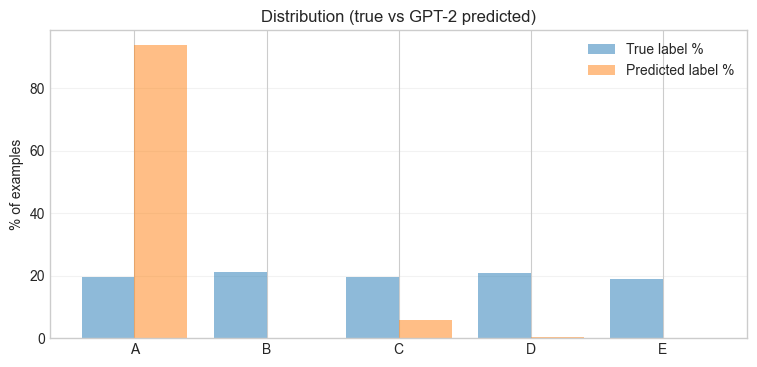

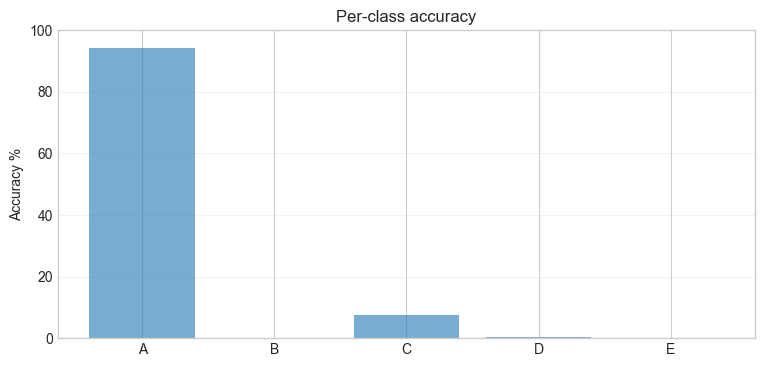

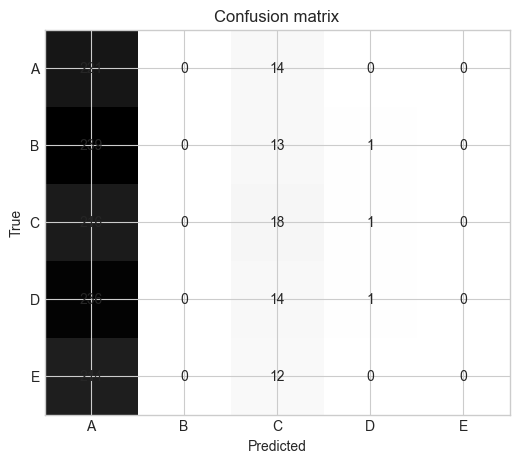

In [4]:
tokens_df = st.tokens.copy().reset_index(drop=True)
N = len(tokens_df)
print("N:", N)

Lp1 = st.arrays()["dec_hidden"][1]   # L+1
W = model.lm_head.weight.detach().to("cpu")
ln_f = model.transformer.ln_f

choice_labels = ["A", "B", "C", "D", "E"]
lab2i = {lab: i for i, lab in enumerate(choice_labels)}

y_true = []
y_pred = []

LIMIT = None  

for i in range(N if LIMIT is None else min(N, LIMIT)):
    row = tokens_df.iloc[i]
    eid = row["example_id"]
    lab_correct = row["answerKey"]

    enc = st.encodings(eid)
    mask = np.array(enc["attention_mask"], dtype=np.int64)
    pos = int(np.where(mask == 1)[0][-1])  

    Hs = st.hidden(eid, side="dec")       
    h_last = torch.tensor(Hs[-1, pos, :], dtype=torch.float32)
    h_last = ln_f(h_last)                 

    logits5 = []
    for lab in choice_labels:
        tid = choice_token_first[lab]
        logits5.append(float(torch.dot(h_last, W[tid])))
    pred_lab = choice_labels[int(np.argmax(np.array(logits5)))]

    y_true.append(lab_correct)
    y_pred.append(pred_lab)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = 100.0 * np.mean(y_true == y_pred)
print(f"Accuracy (A..E argmax at last active token): {acc:.2f}%")

# distributions
counts_true = np.array([np.sum(y_true == lab) for lab in choice_labels], dtype=float)
counts_pred = np.array([np.sum(y_pred == lab) for lab in choice_labels], dtype=float)

pct_true = 100.0 * counts_true / max(1, len(y_true))
pct_pred = 100.0 * counts_pred / max(1, len(y_pred))

# true vs predicted distribution
x = np.arange(len(choice_labels))

plt.figure(figsize=(9, 4))
plt.bar(x - 0.2, pct_true, width=0.4, alpha=0.5, label="True label %")
plt.bar(x + 0.2, pct_pred, width=0.4, alpha=0.5, label="Predicted label %")
plt.xticks(x, choice_labels)
plt.ylabel("% of examples")
plt.title("Distribution (true vs GPT-2 predicted)")
plt.legend()
plt.grid(True, axis="y", alpha=0.25)
plt.show()

# per-class accuracy
per_class_acc = []
for lab in choice_labels:
    mask_lab = (y_true == lab)
    if mask_lab.sum() == 0:
        per_class_acc.append(np.nan)
    else:
        per_class_acc.append(100.0 * np.mean(y_pred[mask_lab] == lab))

plt.figure(figsize=(9, 4))
plt.bar(x, per_class_acc, alpha=0.6)
plt.xticks(x, choice_labels)
plt.ylabel("Accuracy %")
plt.title("Per-class accuracy")
plt.ylim(0, 100)
plt.grid(True, axis="y", alpha=0.25)
plt.show()

cm = np.zeros((5, 5), dtype=int)
for t, p in zip(y_true, y_pred):
    cm[lab2i[t], lab2i[p]] += 1

plt.figure(figsize=(6, 5))
plt.imshow(cm, aspect="auto")
plt.xticks(np.arange(5), choice_labels)
plt.yticks(np.arange(5), choice_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
for r in range(5):
    for c in range(5):
        plt.text(c, r, str(cm[r, c]), ha="center", va="center")
plt.show()

As could be expected given the low performence gpt2, has taken a rather simple approach , here it transpieres as predicting almost all A's. One reason i could think of that would explain it, would be that given it is not a classification head but rather a model aimed at predicting the very next token that does not have to precisely be an answear. Out of all the tokens we look to so A..E,  the token 'A' is the most common one in it's BPE vocabulary.
Another thing is that in natural text, a very common continuation after a being asked a question is starting an answear with the token 'A' .So even beafore accounting for any reasoning the token 'A' has the highest propability.  

That in it self serves as an interesting sub-study on wheather we could intervene on the basis of residual stream or model embeddings etc. In order to steer the model to output A..E token without looking to its trained bias to letter 'A'. 

In [5]:
# pick an example
row0 = st.tokens.iloc[0]
eid = row0["example_id"]
lab_correct = row0["answerKey"]

print("example_id:", eid)
print("answerKey:", lab_correct)
print("text preview:\n", row0["text"][:400], "...\n")

enc = st.encodings(eid)
mask = np.array(enc["attention_mask"], dtype=np.int64)

# LEFT padding => last active token index is last position where mask==1
pos = int(np.where(mask == 1)[0][-1])

T = len(enc["input_ids"])
tok_at_pos = tok.convert_ids_to_tokens([enc["input_ids"][pos]])[0]
print("T:", T, "mask.sum:", int(mask.sum()), "pos(last active):", pos, "token:", tok_at_pos)

Hs = st.hidden(eid, side="dec")  # (L+1, T, D)
print("hidden shape (L+1,T,D):", Hs.shape)

W = model.lm_head.weight.detach().to("cpu")     
ln_f = model.transformer.ln_f                   # final layernormalization

layers = Hs.shape[0]  # L+1
print("layers (L+1):", layers)

layer_logits_5 = []
layer_probs_5  = []
layer_entropy  = []
layer_gap      = []
layer_toplab   = []

for li in range(layers):
    h = torch.tensor(Hs[li, pos, :], dtype=torch.float32)
    h = ln_f(h)  # LOGIT LENS

    logits5 = []
    for lab in choice_labels:
        tid = choice_token_first[lab]
        logits5.append(float(torch.dot(h, W[tid])))
    logits5 = np.array(logits5, dtype=np.float64)

    # softmax over 5 choices
    x = logits5 - logits5.max()
    p = np.exp(x) / np.exp(x).sum()

    # entropy over 5 choices
    ent = float(-(p * np.log(p + 1e-12)).sum())

    # logit gap: correct logit - best other logit
    idx_c = choice_labels.index(lab_correct)
    best_other = np.max(np.delete(logits5, idx_c))
    gap = float(logits5[idx_c] - best_other)

    # top label among A-E
    toplab = choice_labels[int(np.argmax(logits5))]

    layer_logits_5.append(logits5)
    layer_probs_5.append(p)
    layer_entropy.append(ent)
    layer_gap.append(gap)
    layer_toplab.append(toplab)

layer_logits_5 = np.stack(layer_logits_5, axis=0)   # (L+1,5)
layer_probs_5  = np.stack(layer_probs_5, axis=0)    # (L+1,5)
layer_entropy  = np.array(layer_entropy)
layer_gap      = np.array(layer_gap)

print("Top labels per layer:", layer_toplab)
print("Final layer top:", layer_toplab[-1])
print("Final P(correct):", float(layer_probs_5[-1, choice_labels.index(lab_correct)]))
print("Final logit gap:", float(layer_gap[-1]))
print("Entropy range:", float(layer_entropy.min()), float(layer_entropy.max()))

example_id: 701fac8b8c04ab56c4394b2e7b2aa8df
answerKey: A
text preview:
 Q: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
Choices:
A: bank
B: library
C: department store
D: mall
E: new york
Answer: ...

T: 97 mask.sum: 54 pos(last active): 96 token: :
hidden shape (L+1,T,D): (13, 97, 768)
layers (L+1): 13
Top labels per layer: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
Final layer top: A
Final P(correct): 0.4651191325824084
Final logit gap: 1.078765869140625
Entropy range: 0.49424432761217507 1.42305276181885


-------------------

# 1. Layerwise probability of the correct answer

Let:

𝐿
 = number of layers


A={A,B,C,D,E} be the answer options


ℓ∈{0,…,L} index layers (including embedding / pre-layer if applicable)

For each layer ℓ, we extract the logits at the final token position and restrict them to the answer-token set A.

then

Let 
𝑧
ℓ
(
𝑎
) denote the logit for answer a∈A at layer ℓ.

compute a restricted softmax over answer options:

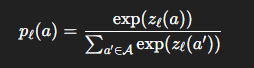

This yields a probability distribution over 
{
𝐴
,
…
,
𝐸
}
 at each layer, conditioned on the full prompt.

----------------

# 2. Layerwise logit gap (decision margin)

Logit gap is defined as : 

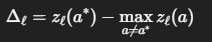

And plotted as : layer_gap = z_correct - z_best_other

!! logits are not transformed via softmax, so the gap reflects raw representational separation instead of a propability.

so the scale is in the logit 'space'

----

# 3. Layerwise entropy over answer options

compute entropy over the answer distribution:

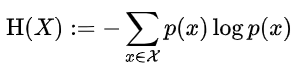

layer_entropy = -np.sum(p * np.log(p), axis=1)

Interpretation

*   High entropy -> uncertainty / indecision

*   Low entropy -> confident commitment to one option

Typical pattern:

*   High entropy in early layers

*   Entropy decreases as layers resolve the answer

*   Final layers show sharp, low-entropy distributions

-----

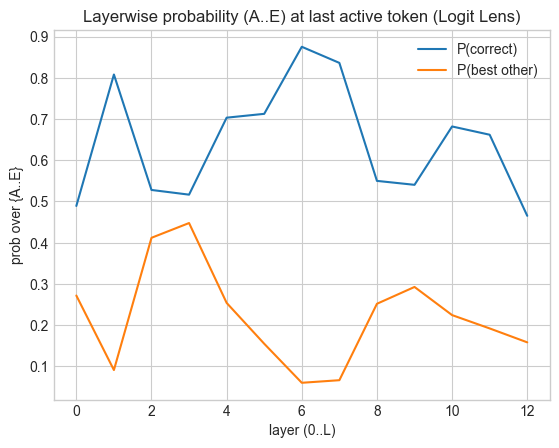

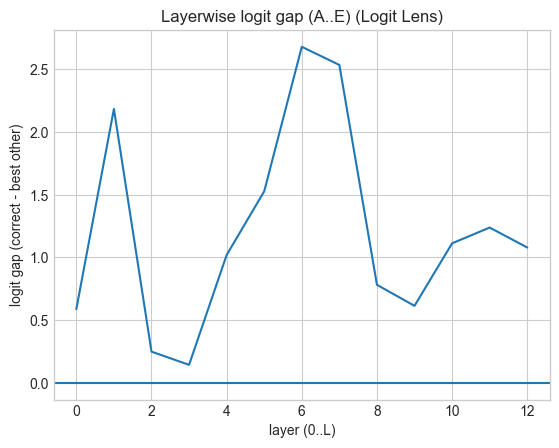

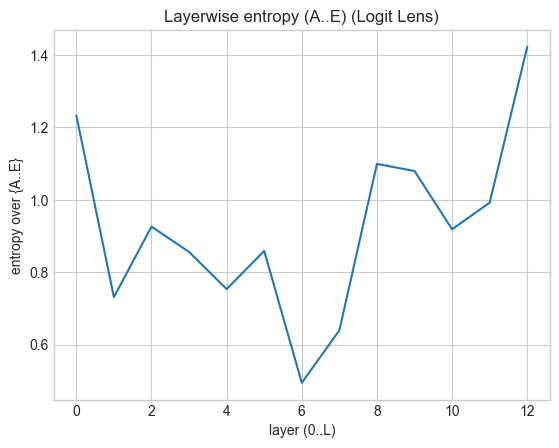

In [6]:
Lp1 = layer_probs_5.shape[0]
x = np.arange(Lp1)

idx_c = choice_labels.index(lab_correct)
p_correct = layer_probs_5[:, idx_c]
p_best_other = np.max(np.delete(layer_probs_5, idx_c, axis=1), axis=1)

plt.figure()
plt.plot(x, p_correct, label="P(correct)")
plt.plot(x, p_best_other, label="P(best other)")
plt.xlabel("layer (0..L)")
plt.ylabel("prob over {A..E}")
plt.title("Layerwise probability (A..E) at last active token (Logit Lens)")
plt.legend()
plt.show()

plt.figure()
plt.plot(x, layer_gap)
plt.axhline(0.0)
plt.xlabel("layer (0..L)")
plt.ylabel("logit gap (correct - best other)")
plt.title("Layerwise logit gap (A..E) (Logit Lens)")
plt.show()

plt.figure()
plt.plot(x, layer_entropy)
plt.xlabel("layer (0..L)")
plt.ylabel("entropy over {A..E}")
plt.title("Layerwise entropy (A..E) (Logit Lens)")
plt.show()

N: 1200
L+1: 13
correct_final: 240 wrong_final: 960


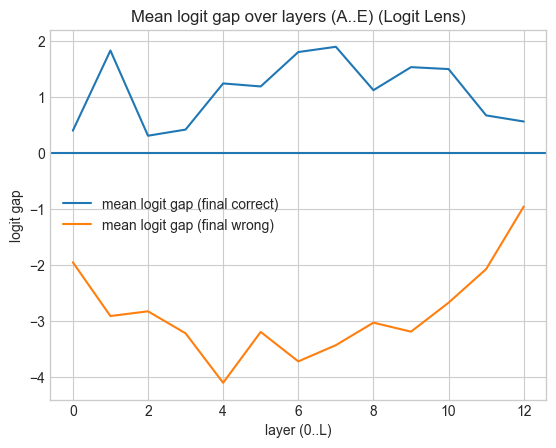

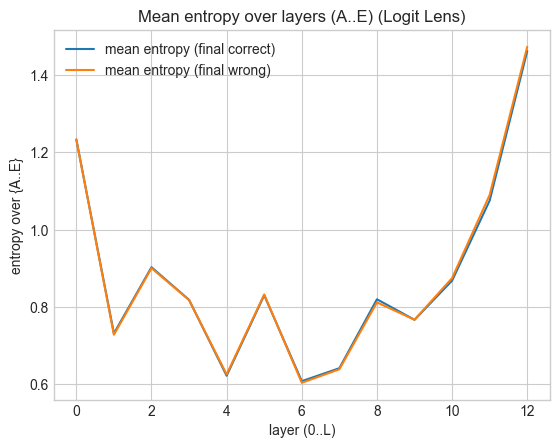

In [7]:
tokens_df = st.tokens.copy().reset_index(drop=True)
N = len(tokens_df)
print("N:", N)

Lp1 = st.arrays()["dec_hidden"][1]  
print("L+1:", Lp1)

W = model.lm_head.weight.detach().to("cpu")
ln_f = model.transformer.ln_f

mean_gap_correct = np.zeros(Lp1, dtype=np.float64)
mean_gap_wrong   = np.zeros(Lp1, dtype=np.float64)
mean_ent_correct = np.zeros(Lp1, dtype=np.float64)
mean_ent_wrong   = np.zeros(Lp1, dtype=np.float64)

cnt_c = 0
cnt_w = 0

LIMIT = None  

for i in range(N if LIMIT is None else min(N, LIMIT)):
    row = tokens_df.iloc[i]
    eid = row["example_id"]
    lab_correct = row["answerKey"]

    enc = st.encodings(eid)
    mask = np.array(enc["attention_mask"], dtype=np.int64)

    # LEFT padding => last active token
    pos = int(np.where(mask == 1)[0][-1])

    Hs = st.hidden(eid, side="dec")  

    gaps = []
    ents = []
    tops = []

    for li in range(Lp1):
        h = torch.tensor(Hs[li, pos, :], dtype=torch.float32)
        h = ln_f(h)  

        logits5 = []
        for lab in choice_labels:
            tid = choice_token_first[lab]
            logits5.append(float(torch.dot(h, W[tid])))
        logits5 = np.array(logits5, dtype=np.float64)

        x = logits5 - logits5.max()
        p = np.exp(x) / np.exp(x).sum()

        ent = float(-(p * np.log(p + 1e-12)).sum())
        idx_c = choice_labels.index(lab_correct)
        best_other = np.max(np.delete(logits5, idx_c))
        gap = float(logits5[idx_c] - best_other)

        top = choice_labels[int(np.argmax(logits5))]

        gaps.append(gap)
        ents.append(ent)
        tops.append(top)

    gaps = np.array(gaps, dtype=np.float64)
    ents = np.array(ents, dtype=np.float64)

    correct_final = (tops[-1] == lab_correct)
    if correct_final:
        mean_gap_correct += gaps
        mean_ent_correct += ents
        cnt_c += 1
    else:
        mean_gap_wrong += gaps
        mean_ent_wrong += ents
        cnt_w += 1

print("correct_final:", cnt_c, "wrong_final:", cnt_w)

mean_gap_correct /= max(cnt_c, 1)
mean_gap_wrong   /= max(cnt_w, 1)
mean_ent_correct /= max(cnt_c, 1)
mean_ent_wrong   /= max(cnt_w, 1)

x = np.arange(Lp1)

plt.figure()
plt.plot(x, mean_gap_correct, label="mean logit gap (final correct)")
plt.plot(x, mean_gap_wrong, label="mean logit gap (final wrong)")
plt.axhline(0.0)
plt.xlabel("layer (0..L)")
plt.ylabel("logit gap")
plt.title("Mean logit gap over layers (A..E) (Logit Lens)")
plt.legend()
plt.show()

plt.figure()
plt.plot(x, mean_ent_correct, label="mean entropy (final correct)")
plt.plot(x, mean_ent_wrong, label="mean entropy (final wrong)")
plt.xlabel("layer (0..L)")
plt.ylabel("entropy over {A..E}")
plt.title("Mean entropy over layers (A..E) (Logit Lens)")
plt.legend()
plt.show()

-------------------

# Saturation

it is an attempt at quantifing at which layer the model’s predicted answer becomes stable and never changes again up to the final layer.

following *Patience-based Early Exit*  and defining a **saturation (exit) layer**
as the earliest layer where the model’s predicted label stays unchanged for **t consecutive layers**. [:contentReference\[oaicite:1\]{index=1}](https://proceedings.neurips.cc/paper_files/paper/2020/file/d4dd111a4fd973394238aca5c05bebe3-Paper.pdf)

This is the simplest definition presented below :

----------------------

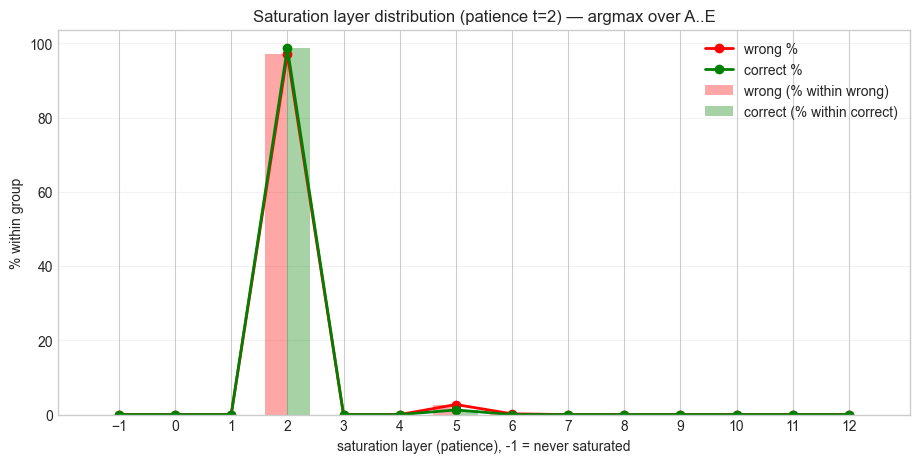

In [ ]:
t = 4  # consecutive layers with same argmax to declare "saturated"  

sat_layers = []
final_correct_flags = []

tokens_df = st.tokens.copy().reset_index(drop=True)
N = len(tokens_df)
Lp1 = st.arrays()["dec_hidden"][1]

W = model.lm_head.weight.detach().to("cpu")
ln_f = model.transformer.ln_f

LIMIT = None  

for i in range(N if LIMIT is None else min(N, LIMIT)):
    row = tokens_df.iloc[i]
    eid = row["example_id"]
    lab_correct = row["answerKey"]

    enc = st.encodings(eid)
    mask = np.array(enc["attention_mask"], dtype=np.int64)

    # LEFT padding => last active token position
    pos = int(np.where(mask == 1)[0][-1])

    Hs = st.hidden(eid, side="dec") 

    tops = []
    for li in range(Lp1):
        h = torch.tensor(Hs[li, pos, :], dtype=torch.float32)
        h = ln_f(h)  # LOGIT LENS

        logits5 = []
        for lab in choice_labels:
            tid = choice_token_first[lab]
            logits5.append(float(torch.dot(h, W[tid])))

        tops.append(choice_labels[int(np.argmax(np.array(logits5)))])

    # patience counter
    cnt = 0
    sat_layer = -1
    for li in range(Lp1):
        if li == 0:
            cnt = 0
        else:
            cnt = (cnt + 1) if (tops[li] == tops[li - 1]) else 0

        if sat_layer == -1 and cnt >= t:
            sat_layer = li

    sat_layers.append(sat_layer)
    final_correct_flags.append(tops[-1] == lab_correct)

sat_layers = np.array(sat_layers, dtype=int)
final_correct_flags = np.array(final_correct_flags, dtype=bool)

sat_correct = sat_layers[final_correct_flags]
sat_wrong   = sat_layers[~final_correct_flags]

bins = np.arange(-1.5, Lp1 + 0.5, 1)
x = np.arange(-1, Lp1)  

cnt_correct, _ = np.histogram(sat_correct, bins=bins)
cnt_wrong,   _ = np.histogram(sat_wrong,   bins=bins)

N_correct = max(1, len(sat_correct))
N_wrong   = max(1, len(sat_wrong))

pct_correct = 100.0 * cnt_correct / N_correct
pct_wrong   = 100.0 * cnt_wrong   / N_wrong

plt.figure(figsize=(11, 5))
plt.bar(x - 0.2, pct_wrong,   width=0.4, color="red",   alpha=0.35, label="wrong (% within wrong)")
plt.bar(x + 0.2, pct_correct, width=0.4, color="green", alpha=0.35, label="correct (% within correct)")
plt.plot(x, pct_wrong,   color="red",   marker="o", linewidth=2, label="wrong %")
plt.plot(x, pct_correct, color="green", marker="o", linewidth=2, label="correct %")

plt.xticks(x)
plt.xlabel("saturation layer (patience), -1 = never saturated")
plt.ylabel("% within group")
plt.title(f"Saturation layer distribution (patience t={t}) — argmax over A..E")
plt.legend()
plt.grid(True, axis="y", alpha=0.25)
plt.show()

----

# Saturation cdn.

More promissing ways to define saturation:

*   Entropy saturation: output distribution becomes very peaked (low entropy), or the margin between #1 and #2 logits stops increasing.

*   Representation convergence: residual stream stop changing much.https://arxiv.org/pdf/2410.11451

*   Attention saturation: attention weights become near one-hot ( or stable across layers), so later layers mostly “copy the same thing”. https://aclanthology.org/2025.emnlp-main.421.pdf

------------